In [1]:
from typing import Iterable, List, Tuple
from pathlib import Path
from datetime import datetime, timedelta

import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import seaborn as sns
import librosa
import librosa.display
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

import IPython.display as ipd

SEED = 42

np.random.seed(SEED)

# Пожалуйста, оставьте оценку и отзыв на портале 🙏

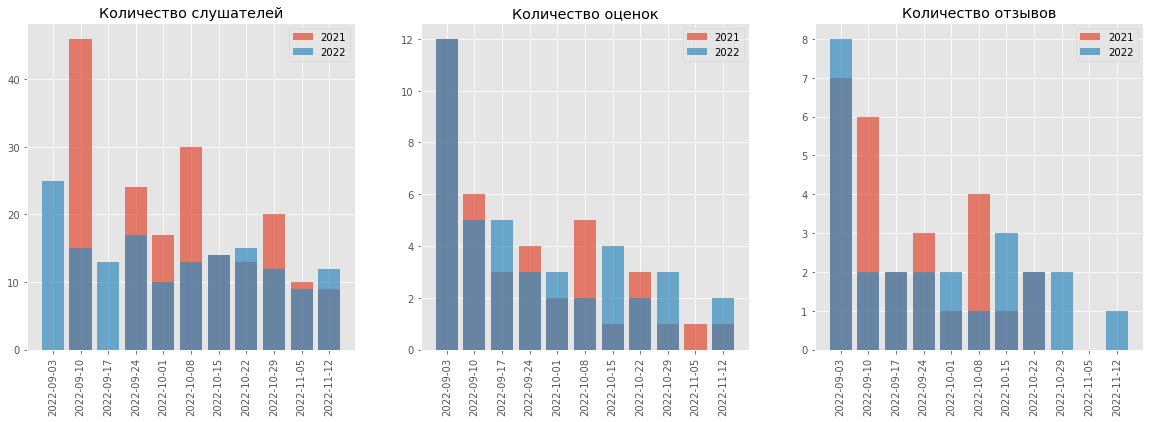

In [2]:
DATE_FORMAT = "%Y-%m-%d"
start_date = datetime.strptime("2022-09-03", DATE_FORMAT) 
lecture_count = 11
dates = [(start_date + timedelta(weeks=i)).strftime(DATE_FORMAT)
         for i in range(lecture_count)]

data = {
    '2021': (
        [0, 46, 0, 24, 17, 30, 14, 13, 20, 10, 9],
        [12, 6, 3, 4, 2, 5, 1, 3, 1, 1, 1],
        [7, 6, 2, 3, 1, 4, 1, 2, 0, 0, 0]
    ),
    '2022': (
        [25, 15, 13, 17, 10, 13, 14, 15, 12, 9, 12],
        [12, 5, 5, 3, 3, 2, 4, 2, 3, 0, 2],
        [8, 2, 2, 2, 2, 1, 3, 2, 2, 0, 1]
    )
}

plt.figure(figsize=(20,6))

for label, sample in data.items():
    student_count, rating_count, review_count = sample

    plt.subplot(131)
    plt.bar(dates, student_count, label=label, alpha=0.7)
    plt.xticks(rotation=90)
    plt.title("Количество слушателей")
    plt.legend()
    plt.subplot(132)
    plt.bar(dates, rating_count, label=label, alpha=0.7)
    plt.xticks(rotation=90)
    plt.title("Количество оценок")
    plt.legend()
    plt.subplot(133)
    plt.bar(dates, review_count, label=label, alpha=0.7)
    plt.xticks(rotation=90)
    plt.title("Количество отзывов")
    plt.legend()
    
plt.show();

# Постановка задачи

Для каждой арабской цифры имеется запись произношения на английском языке разными дикторами (`./data/audio_mnist`)

Требуется построить модель для классификации цифр

In [3]:
TRAIN_PATH = Path("./data/audio_mnist")

Первый символ в названии файлов соответствует целевой переменной, затем указан некоторый идентификатор данного класса

In [4]:
# Uncomment if you are using colab
# !mkdir ./data

# !wget https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture08/data/audio_mnist.zip -O ./data/audio_mnist.zip
# !wget https://raw.githubusercontent.com/vadim0912/MLIntro2022_Spring/main/lecture08/data/HNY.wav -O ./data/HNY.wav

In [5]:
# %%bash
# unzip ./data/audio_mnist.zip -d ./data/audio_mnist

In [6]:
[x.name for i, x in enumerate(TRAIN_PATH.iterdir()) if i < 10]

['3_14.wav',
 '8_129.wav',
 '8_115.wav',
 '3_28.wav',
 '4_21.wav',
 '5_122.wav',
 '4_35.wav',
 '5_136.wav',
 '8_101.wav',
 '1_8.wav']

In [7]:
ipd.Audio(TRAIN_PATH / "0_3.wav")

	Построить модель для определенной цифры
	Построить модель, позволяющую распознавать все цифры (multilabel или multiclass?)

# Представление данных

[источник изображения](https://christophm.github.io/interpretable-ml-book/agnostic.html)

<img src="./images/interpretable_ml.png" alt="" style="width: 400px;"/>

## аудиозаписи

* что такое звук?
* подойдет ли исходный сигнал для использования в качестве признаков в машинном обучении?

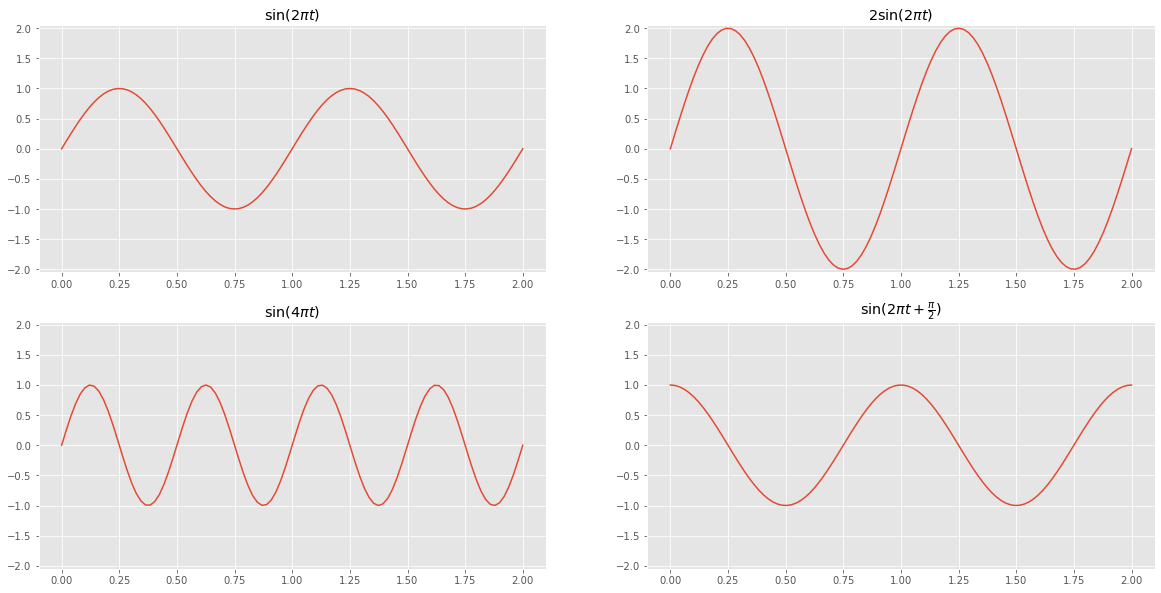

In [8]:
t = np.linspace(0, 2, 100)

fig, ax  = plt.subplots(nrows=2, ncols=2, figsize=(20,10))

ax[0,0].set_title(r"$\sin(2\pi t)$")
ax[0,0].plot(t, np.sin(2 * np.pi * t))
ax[0,0].set_ylim([-2.05, 2.05])

ax[0,1].set_title(r"$2 \sin(2\pi t)$")
ax[0,1].plot(t, 2 * np.sin(2 * np.pi * t))
ax[0,1].set_ylim([-2.05, 2.05])

ax[1,0].set_title(r"$\sin(4\pi t)$")
ax[1,0].plot(t, np.sin(2 * 2 * np.pi * t))
ax[1,0].set_ylim([-2.05, 2.05])

ax[1,1].set_title(r"$\sin(2\pi t + \frac{\pi}{2})$")
ax[1,1].plot(t, np.sin(2 * np.pi * t + np.pi / 2))
ax[1,1].set_ylim([-2.05, 2.05]);

Реальные сигналы сложные

In [9]:
frequency = 300
SR = 22050
T = 6.0

t = np.linspace(0, T, int(T * SR))
music = np.sin(2 * np.pi * frequency * t)
ipd.Audio(music, rate=SR)

![alt text](./images/discretization.png)

**Терминология**: [librosa glossary](https://librosa.github.io/librosa/glossary.html)

### Aliasing

выбор [частоты дискретизации](https://ru.wikipedia.org/wiki/%D0%A7%D0%B0%D1%81%D1%82%D0%BE%D1%82%D0%B0_%D0%B4%D0%B8%D1%81%D0%BA%D1%80%D0%B5%D1%82%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D0%B8) **[важен](https://ru.wikipedia.org/wiki/%D0%90%D0%BB%D0%B8%D0%B0%D1%81%D0%B8%D0%BD%D0%B3)**

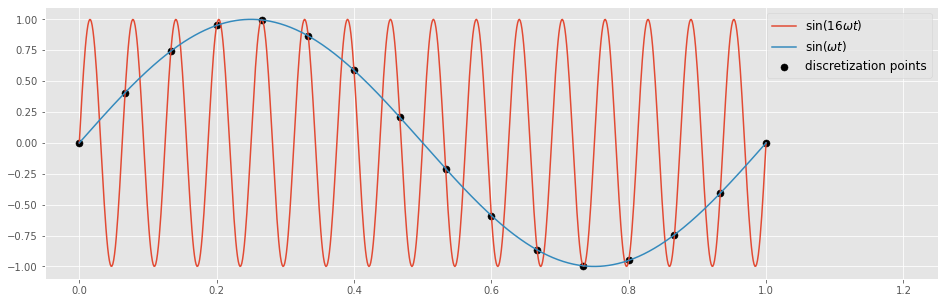

In [10]:
t1 = np.linspace(0, 1, 16)
t2 = np.linspace(0, 1, 800)

sin_v = lambda x: np.sin(2 * np.pi * x)
sin_16v = lambda x: np.sin(2 * np.pi * 16 * x)

plt.figure(figsize=(16,5))
plt.plot(t2, sin_16v(t2), label=r"$\sin(16 \omega t)$")
plt.plot(t2, sin_v(t2), label=r"$\sin(\omega t)$")
plt.scatter(t1, sin_v(t1), label="discretization points", color='k', s=50)
plt.legend(fontsize=12)
plt.xlim([-0.05, 1.25]);

для оцифровки сигнала на частотах не выше $f$ частота дискретизации должна быть > $2f$ (формально можно посмотреть в [Теореме Котельникова-Шеннона](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%9A%D0%BE%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%B8%D0%BA%D0%BE%D0%B2%D0%B0))

### Сигнал

#### Воспроизвести

In [11]:
for target in range(10):
    for file_path in TRAIN_PATH.iterdir():
        if int(file_path.stem[0]) == target:
            ipd.display(ipd.Audio(file_path))
            break

#### Визуализировать

Можно было и [scipy](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.io.wavfile.read.html) использовать

In [12]:
def load_wav(path: Path, sr: int=8000) -> Tuple[np.ndarray, int]:
    return librosa.load(path, sr=sr)

In [13]:
signal, sr = load_wav(TRAIN_PATH / '0_3.wav')

In [14]:
ipd.Audio(TRAIN_PATH / '0_3.wav')

In [15]:
print("duration: {} seconds".format(signal.size / sr))

duration: 0.67425 seconds


In [16]:
time_axis = 1000 * np.arange(len(signal)) / sr

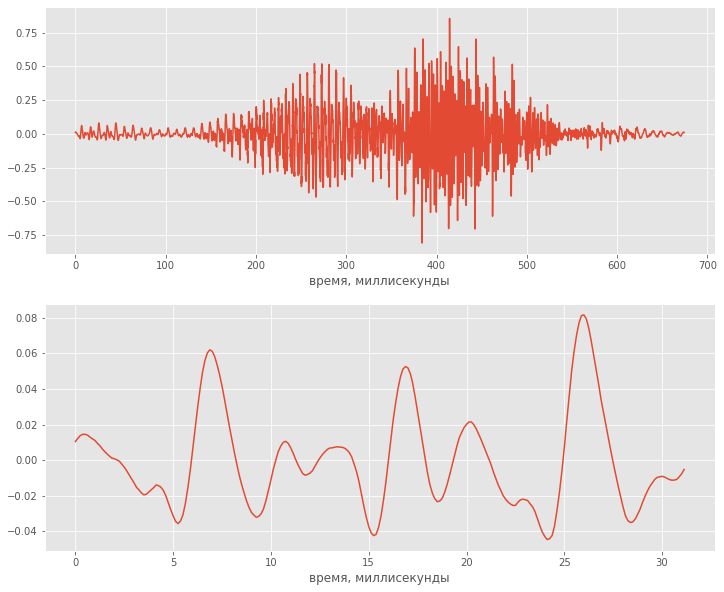

In [17]:
sample_size = 250

plt.figure(figsize=(12, 10))
plt.subplot(211)
plt.plot(time_axis, signal)
plt.xlabel("время, миллисекунды")

plt.subplot(212)
plt.plot(time_axis[:sample_size], signal[:sample_size])
plt.xlabel("время, миллисекунды");

С какими проблемами можно столкнуться при попытках обучения модели на сырых записях (waveform'ах)?

### Спектр

* что такое преобразование Фурье?
* в чем его физический смысл?

#### Преобразование Фурье

In [18]:
def time_vs_frequency(x, y):
    spectral_power = np.abs(np.fft.fft(y) ** 2)
    spectral_power = spectral_power[:spectral_power.size // 2]

    plt.figure(figsize=(12,5))
    plt.subplot(121)
    plt.plot(x, y)
    plt.subplot(122)
    plt.stem(spectral_power);
    
def sin_sum(x: np.ndarray) -> np.ndarray:
    return np.sin(x) + np.sin(10 * x) * 0.5 + np.sin(20 * x) * 0.5

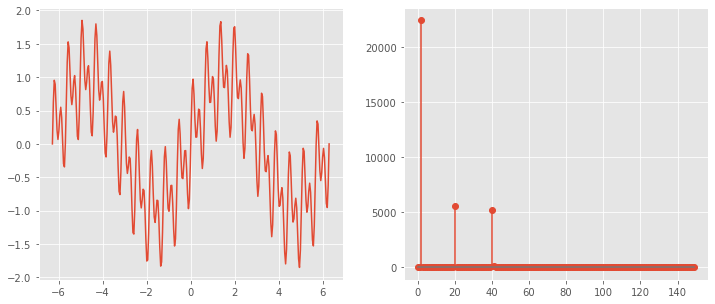

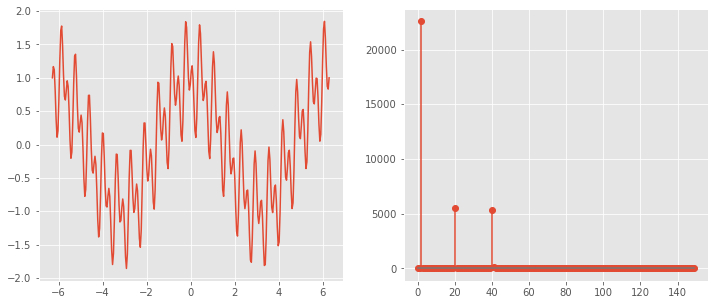

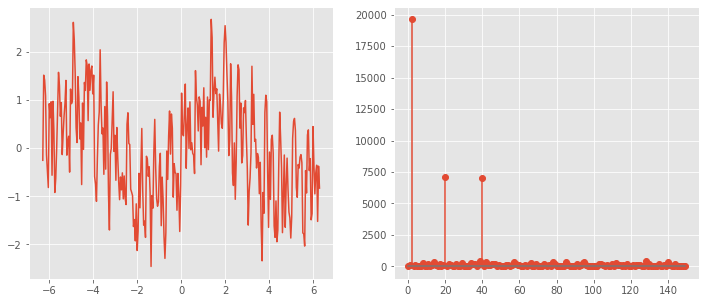

In [19]:
x = np.linspace(-2 * np.pi, 2 * np.pi, 300)

noise = np.random.uniform(-1, 1, size=x.size)


time_vs_frequency(x, sin_sum(x))
time_vs_frequency(x, sin_sum(x + np.pi / 2))
time_vs_frequency(x, sin_sum(x) + noise)

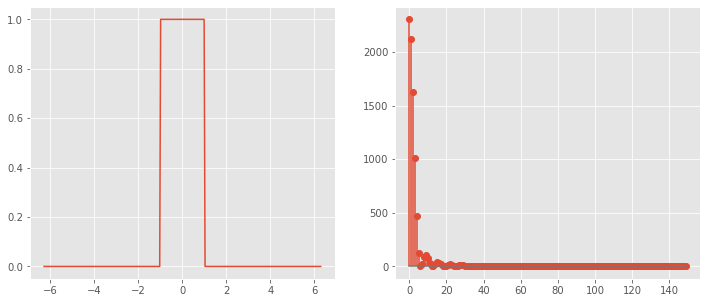

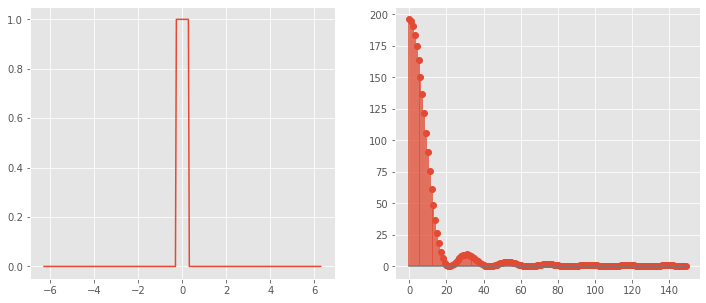

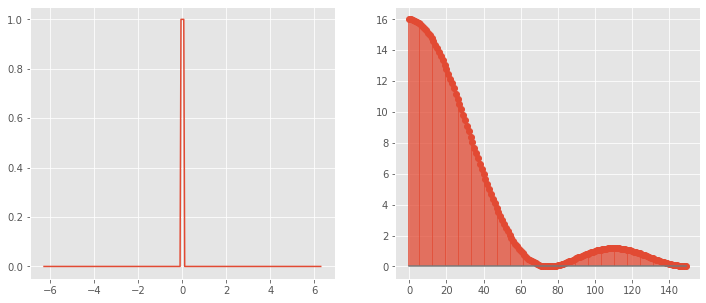

In [20]:
time_vs_frequency(x, (np.abs(x) < 1).astype(int))
time_vs_frequency(x, (np.abs(x) < 0.3).astype(int))
time_vs_frequency(x, (np.abs(x) < 0.1).astype(int))

#### Спектральная фильтрация

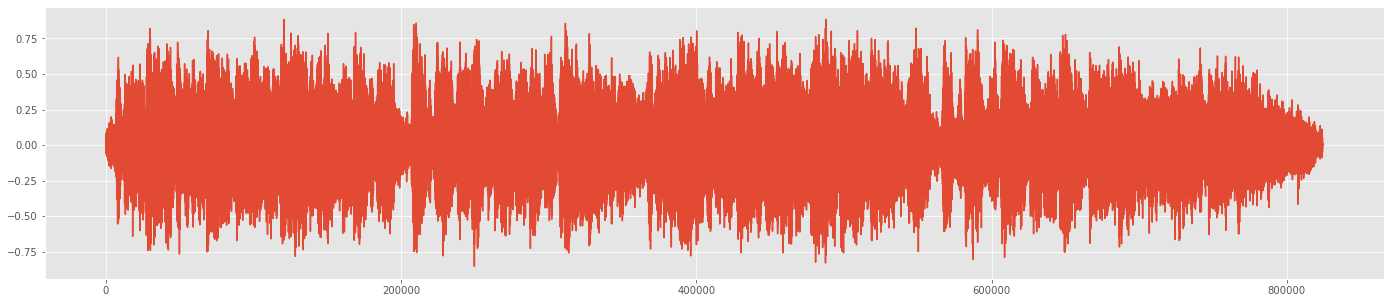

In [21]:
abba, sr = load_wav("./data/HNY.wav", sr=22050)

plt.figure(figsize=(24,5))
plt.plot(abba);

ipd.Audio(data=abba, rate=sr)

In [22]:
spectrum = np.fft.fft(abba)

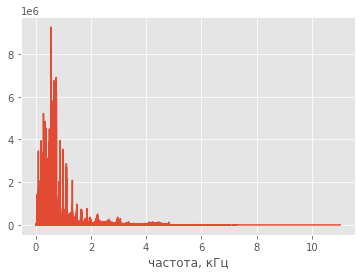

In [23]:
freq_khz = np.arange(spectrum.size  // 2) * (sr / abba.size) / 1000.0

plt.plot(freq_khz, np.abs(spectrum ** 2)[:spectrum.size // 2])
plt.xlabel("частота, кГц");

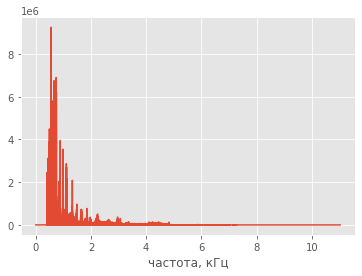

In [24]:
mask = np.ones(spectrum.size)

mask[:15000] = 0
mask[-15000:] = 0

restored_signal = np.real(np.fft.ifft(spectrum * mask))

ipd.display(ipd.Audio(restored_signal, rate=sr))

plt.plot(freq_khz, np.abs((spectrum * mask) ** 2)[:spectrum.size // 2])
plt.xlabel("частота, кГц");

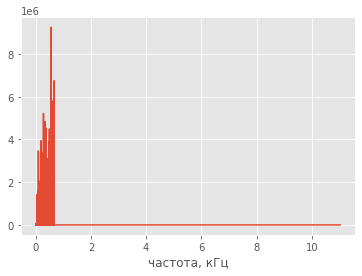

In [25]:
mask = np.zeros(spectrum.size)

mask[:25000] = 1
mask[-25000:] = 1

restored_signal = np.real(np.fft.ifft(spectrum * mask))

ipd.display(ipd.Audio(restored_signal, rate=sr))

plt.plot(freq_khz, np.abs((spectrum * mask) ** 2)[:spectrum.size // 2])
plt.xlabel("частота, кГц");

#### Спектр сигнала

In [26]:
spectrum = np.fft.fft(signal)

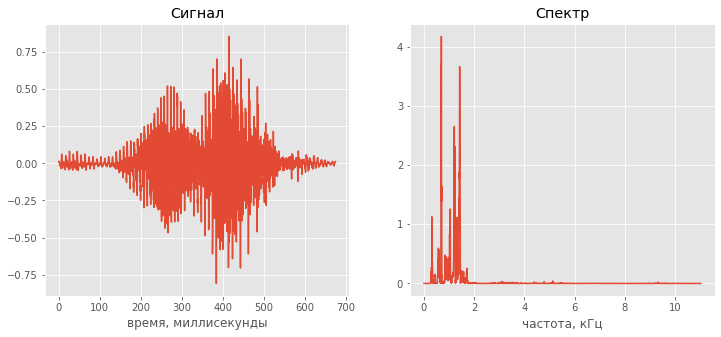

In [27]:
spectrum = np.abs(spectrum[:spectrum.size // 2] ** 2)
spectrum /= spectrum.size
freq_khz = np.arange(spectrum.size) * (sr / signal.size) / 1000.0

plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.title("Сигнал")
plt.plot(time_axis, signal)
plt.xlabel("время, миллисекунды")
plt.subplot(122)
plt.title("Спектр")
plt.plot(freq_khz, spectrum)
plt.xlabel("частота, кГц")
plt.show()

In [28]:
signal.size

5394

#### STFT: Short Time Fourier Transform

Рассмотрим импульс на иинтервале от $0$ до $T$

$$\Large
e^{-\frac{(t - T/2)^2}{\beta}} \sin(2\pi\nu t + \alpha t^2) 
$$

In [29]:
frequency = 300
sr = 8000
T = 6.0

t = np.linspace(0, T, int(T * sr))

music1 = np.sin(2 * np.pi * frequency * t + 48 * np.pi * t ** 2) * np.exp(- (t - T / 2) ** 2 / 3)
music2 = music1[::-1]

ipd.display(ipd.Audio(music1, rate=sr))
ipd.display(ipd.Audio(music2, rate=sr))

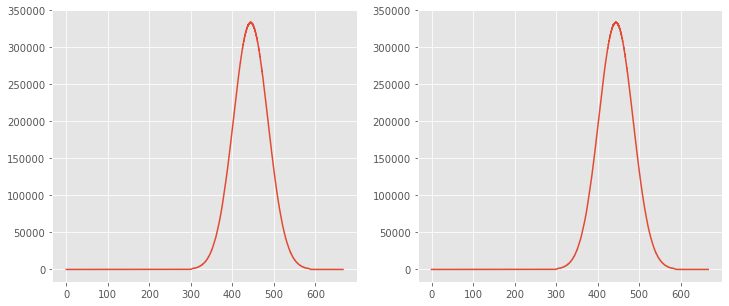

In [30]:
subset = 4000

spectrum1 = np.fft.fft(music1)
spectrum1 = np.abs(spectrum1[:spectrum1.size // 2] ** 2)[:subset]

spectrum2 = np.fft.fft(music2)
spectrum2 = np.abs(spectrum2[:spectrum2.size // 2] ** 2)[:subset]

freq_hz = np.arange(spectrum1.size)[:subset] * (sr / music1.size)


plt.figure(figsize=(12, 5))
plt.subplot(121)
plt.plot(freq_hz, spectrum1)
plt.subplot(122)
plt.plot(freq_hz, spectrum2)
plt.show()

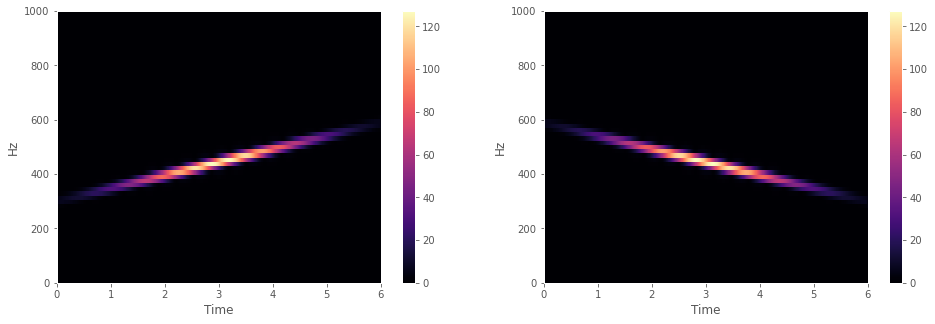

In [31]:
hop_length = 80
n_fft = 512

spectrogram1 = np.abs(librosa.stft(
    music1, n_fft=n_fft, hop_length=hop_length
))
spectrogram2 = np.abs(librosa.stft(
    np.asfortranarray(music2), n_fft=n_fft, hop_length=hop_length
))
plt.figure(figsize=(16,5))
plt.subplot(121)
librosa.display.specshow(
    spectrogram1, sr=sr, hop_length=hop_length,
    x_axis='time', y_axis='hz'
)
plt.ylim([0, 1000])
plt.colorbar()
plt.subplot(122)
librosa.display.specshow(
    spectrogram2, sr=sr, hop_length=hop_length,
    x_axis='time', y_axis='hz'
)
plt.colorbar()
plt.ylim([0, 1000])
plt.show()

[источник изображения](https://www.mathworks.com/help/signal/ref/stft.html)

<img src="./images/iscola_stft.png" alt="" style="width: 600px;"/>

In [32]:
hop_length = 80
n_fft = 184

spectrogram = np.abs(librosa.stft(
    signal, n_fft=n_fft, hop_length=hop_length
))

физический смысл:

`n_fft`: определяет число отсчетов(ширину окна), которые поступают в Фурье-преобразование

`hop_length` - определяет сдвиг окна между соседними преобразованиями Фурье

Ширина окна в секундах:

In [33]:
n_fft / sr

0.023

Шаг между соседними окнами в секундах:

In [34]:
hop_length / sr

0.01

Сколько всего было Фурье-преобразований:

In [35]:
(signal.size / sr) / (hop_length / sr)

67.425

In [36]:
spectrogram.shape

(93, 68)

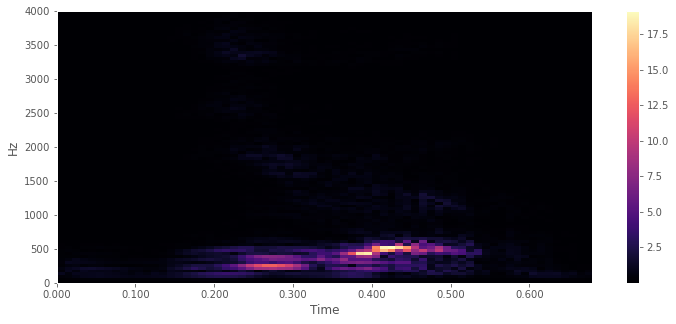

In [37]:
plt.figure(figsize=(12,5))
librosa.display.specshow(
    spectrogram, sr=sr, hop_length=hop_length,
    x_axis='time', y_axis='hz'
)
plt.colorbar();

Почти вся область черная. Где-то ошибка?

<details>
    <summary><b>Ответ</b></summary>
  
  Ошибки нет, спектр сигнала преимущественно сосредоточен до 500 Гц <br>
  Человек слышит на частотах от 20 Гц до 20 кГц (упомянуть `sample_rate` для музыки)<br>
  Говорит на частотах от 300 Гц до 4кГц (упомянуть `sample_rate` для телефонии)<br>
</details>

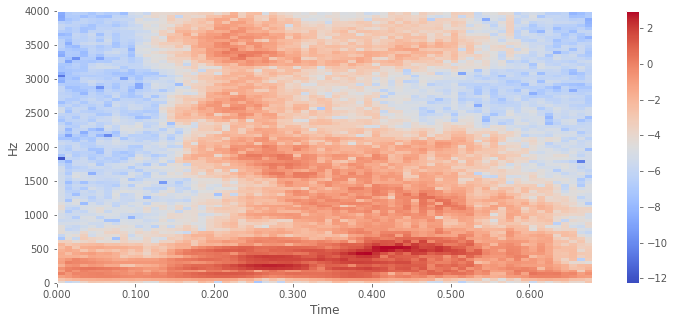

In [38]:
plt.figure(figsize=(12,5))
librosa.display.specshow(
    np.log(1e-20 + spectrogram), sr=sr, hop_length=hop_length,
    x_axis='time', y_axis='hz', cmap="coolwarm"
)
plt.colorbar();

#### [Мел-шкала](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D0%BB_%28%D0%B2%D1%8B%D1%81%D0%BE%D1%82%D0%B0_%D0%B7%D0%B2%D1%83%D0%BA%D0%B0%29)

1) Размерность вектора после Фурье преобразования слишком большая

2) Человек легко отличит 500 Hz от 1000 Hz, с 8500 Hz и 9000 Hz разница не так очевидна

Чувствительность человеческого уха к звуку зависит от частоты звука: чем ниже частота, тем выше чувствительность

$$m[mel] = 1127 \ln(1 + \frac{f[Hz]}{700})$$

=> не все частотные интервалы спектра одинаково важны, вблизи низких частот интервалы должны быть мельче

In [39]:
frequencies = [300, 400, 800, 900]
SR = 22050
T = 2.0
t = np.linspace(0, T, int(T * SR))

for frequency in frequencies:
    music = np.sin(2 * np.pi * frequency * t)
    ipd.display(ipd.Audio(music, rate=SR))

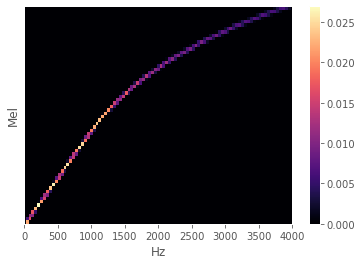

In [40]:
n_mels = 64

mel_scale = librosa.filters.mel(sr=sr, n_fft=n_fft, n_mels=n_mels)

librosa.display.specshow(
    mel_scale, sr=sr, hop_length=hop_length, x_axis='linear'
)
plt.ylabel('Mel')
plt.colorbar();

In [41]:
mel_spectrogram = librosa.feature.melspectrogram(
    signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)

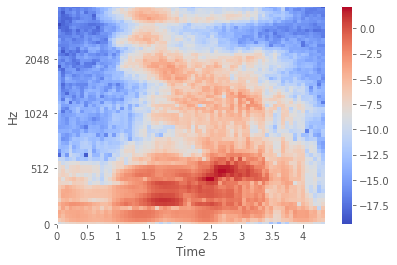

In [42]:
librosa.display.specshow(
    np.log(1e-20 + mel_spectrogram), sr=sr,
    x_axis='time', y_axis='mel', cmap="coolwarm"
)
plt.colorbar();

In [43]:
another_signal, sr = load_wav(TRAIN_PATH / '0_0.wav')

In [44]:
ipd.Audio(another_signal, rate=sr)

In [45]:
another_mel_spectrogram = librosa.feature.melspectrogram(
    another_signal, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels
)

In [46]:
mel_spectrogram.shape, another_mel_spectrogram.shape

((64, 68), (64, 50))

In [47]:
signal.size / sr, another_signal.size / sr

(0.67425, 0.494625)

Для сигналов разной длительности размер спектрограммы разный => количество признаков разное

Как представить сигнал? 

# Метрика

* Accuracy, precision, recall, F-measure, ...
* Какую выбрать?
* Зависит ли это от данных?
* Micro и Macro усреднение
* [Хорошая статья](https://medium.com/usf-msds/choosing-the-right-metric-for-evaluating-machine-learning-models-part-2-86d5649a5428)

![alt text](./images/classic.png)

$$\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}$$

$$\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}$$

$$\text{Recall} = \frac{\text{TP}}{\text{TP} + \text{FN}}$$

$$\text{F-score} = (1 + \alpha)\frac{\text{Precision} * \text{Recall}}{\alpha * \text{Precision} + \text{Recall}}$$

Загадки: `Precision` vs `Recall`
* Вы хорошо решили [соревнование по антипорно](https://www.kaggle.com/c/introml2019-1) и устроились в компанию, которая занимается разработкой фильтра видеороликов для детей. Целевая переменная: 1 -> видеоролик хороший, 0 -> видеоролик плохой
* Диагностика рака. Целевая переменная: 1 -> человек болен, 0 -> здоров
* Антиспам. Целевая переменная: 1 -> спам, 0 -> хорошее письмо
* Компьютерное зрение в супермаркетах. Целевая переменная: 1 -> вор, 0 -> законопослушный гражданин

случай $K$ классов: для каждого $k$ можем вычислить $\text{TP}_k$, $\text{TN}_k$, $\text{FP}_k$, $\text{FN}_k$

$$\text{Precision}_{micro} = \frac{\sum_k{\text{TP}_k}}{\sum_k{\text{TP}_k + \text{FP}_k}}$$

$$\text{Recall}_{micro} = \frac{\sum_k{\text{TP}_k}}{\sum_k{\text{TP}_k + \text{FN}_k}}$$

$$\text{Precision}_{macro} = \frac{1}{K}\sum_k{\frac{\text{TP}_k}{\text{TP}_k + \text{FP}_k}}$$

$$\text{Recall}_{macro} = \frac{1}{K}\sum_k{\frac{\text{TP}_k}{\text{TP}_k + \text{FN}_k}}$$

In [48]:
train_targets = [int(path.stem[0]) for path in TRAIN_PATH.iterdir()]

постройте распределение целевой переменной<br>
есть ли дисбаланс классов?

In [49]:
pd.DataFrame({"target": train_targets}).target.value_counts()

6    156
7    155
0    154
9    151
4    149
1    148
3    147
8    147
5    147
2    146
Name: target, dtype: int64

# Data Explortaion

	Есть ли пропуски?
	Есть ли аномалии? Что считать аномалией?
	Все ли пиксели равноценны? Как это проверить с помощью эвристик и машинного обучения?

In [50]:
def get_duration(path: Path) -> float:
    waveform, sr = load_wav(path)
    return waveform.size / sr

duration_with_path = [
    (get_duration(path), path) for path in TRAIN_PATH.iterdir()
]

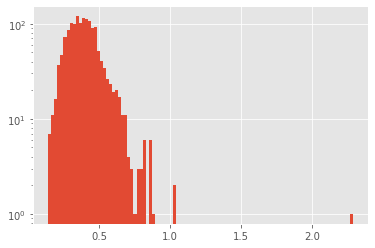

In [51]:
plt.hist([x[0] for x in duration_with_path], bins=100)
plt.yscale('log');

In [52]:
min_duration, min_duration_path = min(duration_with_path)
max_duration, max_duration_path = max(duration_with_path)

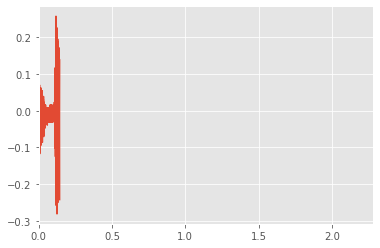

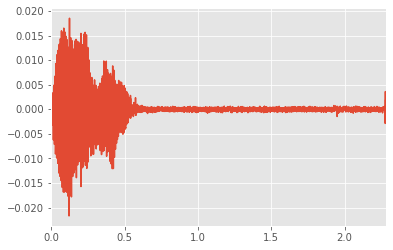

In [53]:
for path in (min_duration_path, max_duration_path):
    ipd.display(ipd.Audio(path))
    wav, sr = load_wav(path)
    plt.plot(np.arange(wav.size) / sr, wav)
    plt.xlim([0, max_duration])
    plt.show()

In [54]:
pathes, y = zip(*[
    (path, int(path.stem[0])) for path in TRAIN_PATH.iterdir()
])

pathes_train, pathes_val, y_train, y_val = train_test_split(pathes, y, test_size=0.3, stratify=y, random_state=SEED)

# Machine Learning

In [55]:
class SpectrogramFeaturizer(BaseEstimator, TransformerMixin):
    
    def __init__(self, sound_features_config: dict, with_std: bool=False) -> None:
        self.sound_features_config = sound_features_config
        self.with_std = with_std
        
    def fit(self, x: np.ndarray, y: np.ndarray=None) -> 'SpectrogramFeaturizer':
        return self
    
    def extract_features(self, path: Path) -> np.ndarray:
        
        signal, sr = load_wav(path, sr=self.sound_features_config['sr'])

        mel_spectrogram = librosa.feature.melspectrogram(signal, **self.sound_features_config)

        log_mel_spectrogram = np.log(1e-20 + mel_spectrogram)

        if self.with_std:
            return np.concatenate([
                log_mel_spectrogram.mean(1),
                log_mel_spectrogram.std(1)
            ]).reshape(1, -1)
        else:
            return log_mel_spectrogram.mean(1).reshape(1, -1)
        
    def transform(self, pathes: List[Path]) -> np.ndarray:
        return np.concatenate([
            self.extract_features(path) for path in pathes
        ])

In [56]:
def plot_conf_matrix(y_test: np.ndarray, y_pred: np.ndarray, annot: bool=False) -> None:
    
    plt.figure(figsize=(8,6))
    plt.title(f"Accuracy: {(y_test == y_pred).mean():.3f}")
    sns.heatmap(
        confusion_matrix(y_test, y_pred),
        linewidths=.5,
        annot=annot
    )
    plt.show()

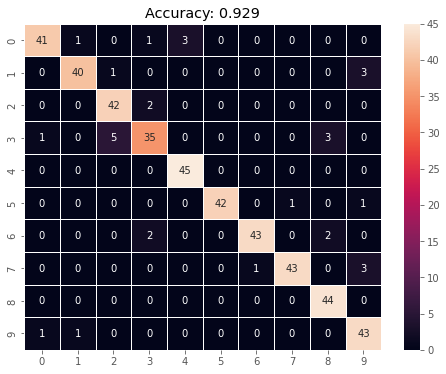

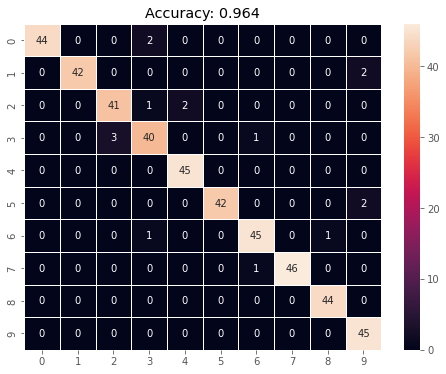

In [57]:
sound_features_config = {
    'n_fft': 512,
    'hop_length': 80,
    'n_mels': 64,
    'sr': 8000
}

for with_std in (False, True):

    pipeline = Pipeline(
        steps=[
            ('featurizer', SpectrogramFeaturizer(sound_features_config, with_std=with_std)),
            ('scale', StandardScaler()),
            ('clf', LogisticRegression(max_iter=10_000))
        ]
    )

    y_val_pred = pipeline.fit(pathes_train, y_train).predict(pathes_val)

    plot_conf_matrix(y_val, y_val_pred, annot=True)

# Ошибки модели

actual: 1 	 predicted: 9


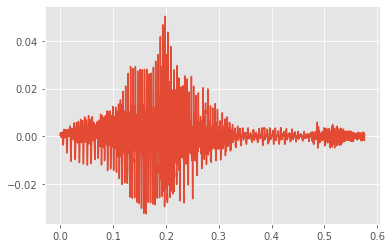

actual: 1 	 predicted: 9


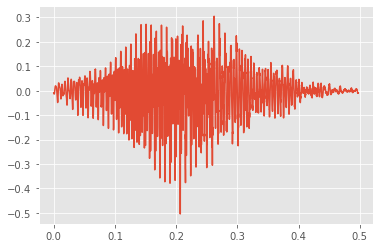

actual: 0 	 predicted: 3


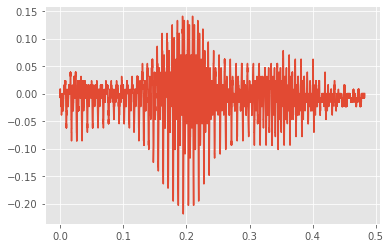

actual: 3 	 predicted: 6


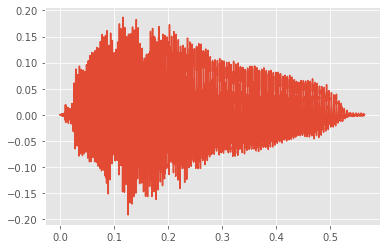

actual: 6 	 predicted: 8


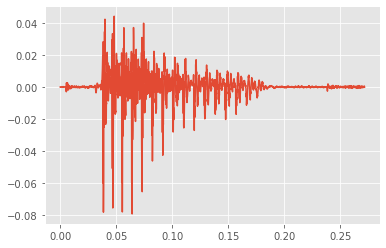

actual: 2 	 predicted: 4


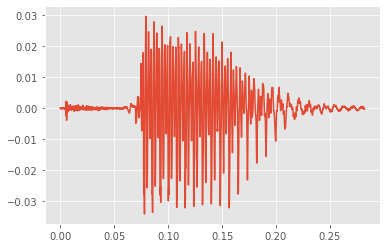

actual: 3 	 predicted: 2


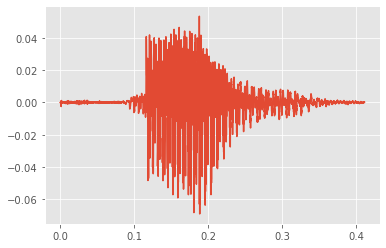

actual: 7 	 predicted: 6


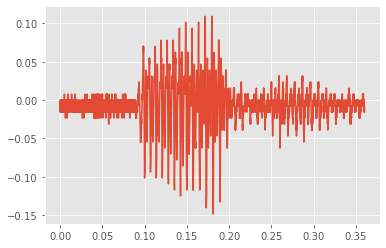

actual: 3 	 predicted: 2


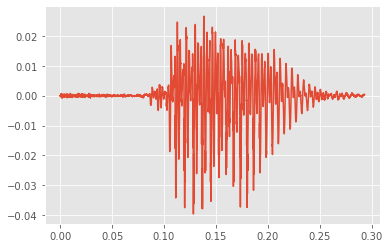

actual: 3 	 predicted: 2


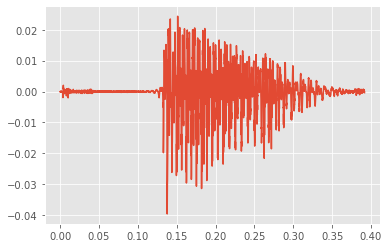

actual: 5 	 predicted: 9


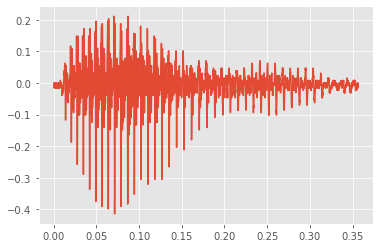

actual: 2 	 predicted: 3


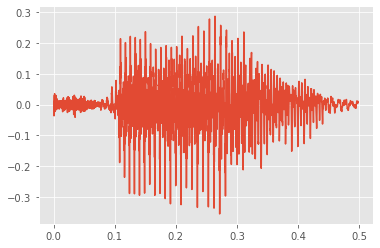

actual: 2 	 predicted: 4


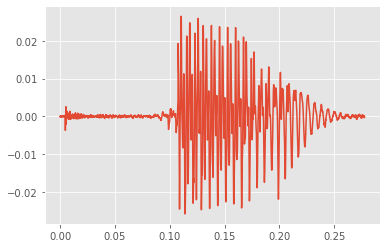

actual: 6 	 predicted: 3


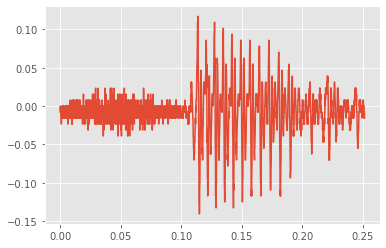

actual: 0 	 predicted: 3


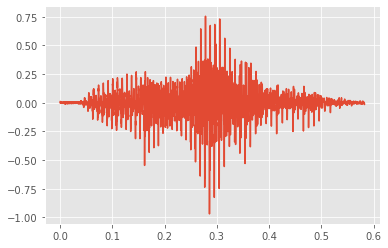

actual: 5 	 predicted: 9


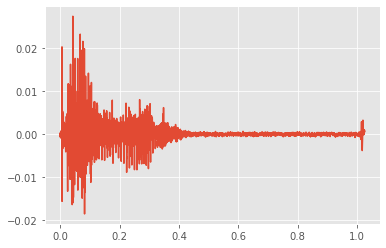

In [58]:
for y_true, y_pred, path in zip(y_val, y_val_pred, pathes_val):
    if y_true != y_pred:
        print(f"actual: {y_true} \t predicted: {y_pred}")
        ipd.display(ipd.Audio(path))
        wav, sr = load_wav(path)
        plt.plot(np.arange(wav.size) / sr, wav)
        plt.show()

# Бонус-1: cool story

**Андрей Плахов** (взято из [телеграм-канала](https://t.me/insilicio)):

Итак, вы ML-специалист, а у вашей команды есть задача, поставленная в бизнес-терминах. В качестве конкретного примера выберем такую: "сдавать недвижимость в аренду максимально эффективно". Очевидно, что задача негладкая: мы или сдали, или нет, тут разрыв даже не первой производной, а самого таргета. Более того, таргет недоопределен на всём множестве возможных решений, т.к. в реальности существуют дополнительные аспекты, вскрывающиеся по ходу дела. Например, если мы ввели в нашу модель фичи, зависящие от предполагаемого арендатора, и поэтому в качестве побочного эффекта стали сдавать тем съемщикам, которым совершенно никто больше не сдаёт и которые готовы за это приплатить, мы можем обнаружить, что износ недвижимости почему-то перестал быть пренебрежимой константой. К тому же в задаче есть элементы аукциона и большая нестабильность во времени. Сложнаааа.

Ок, мы для ясности на всё это забили и решили для начала просто обучить MSE, чтобы он по фичам предсказывал, за какую цену ЭТО можно сдать.
И выяснили, что наша модель даёт MSE 1700 рублей. Хм, ну, вроде бы, неплохо.

Что тут можно сделать дальше:

1) продолжать улучшать MSE, перебирать (гипер)параметры, досыпать фичи и дотренировывать модельку, время от времени высылая заказчикам победные реляции о том, что MSE в новом релизе улучшилось с 1701 до 1689 рублей.

2) всё-таки попробовать понять, как это решение выглядит с точки зрения бизнеса. Давайте предложим им провести эксперимент и сдавать часть недвижимости по цене, предлагаемой моделью. Мы вообще можем такой эксперимент хотя бы провести? Если нет, то что нам мешает? Если можем, то чего нам это стоит и как мы поймем, стало лучше или хуже или пофиг? Очень полезные вопросы.

3) cравнить нашу модель с чем-нибудь. Давайте, например, сравним с моделью "среднюю цену за метр для объектов в радиусе 500м умножить на площадь", у которой есть понятный физический смысл. Какой у неё MSE? Если 2500 рублей, то это одно дело, а если 1400, то мы всё это время чем-то странным занимались. Ой, у нас не хватает данных, чтобы такое сравнение провести? Тогда, наверное, у нас и фичи так себе, и нужно бы ими заняться дополнительно.

4) посмотреть на выбросы, подумать об инвариантах. Если мы обнаруживаем, что наша модель иногда предсказывает, что недвижимость нужно сдавать за цену ниже нуля, потому что Владивосток очень уж далеко от МКАДа, то её, наверное, несложно улучшить.

5) посмотреть на то, как модель себя ведёт на срезах. Например, мы можем обнаружить, что почти вся ошибка определяется более дорогими объектами (как это обычно и бывает для MSE), а на самом деле для них все равно нужен свой процесс даже на уровне бизнеса, и из выборки их нужно было просто выкинуть

Дорогие ML-специалисты, датасайентисты и прочие бигдата-аналитики! Вы никогда, никогда не продвинетесь карьерно, не заработаете столько денег и не принесёте столько пользы человечеству, сколько могли бы (если согласиться принять ту гипотезу, что ML для бизнеса приносит человечеству пользы), если будете считать все задачи, кроме первой, "чужими" или "скучными"!*

# Бонус-2: Дополнительные материалы

* Machine Learning on Music
    * [The Sound of AI](https://www.youtube.com/channel/UCZPFjMe1uRSirmSpznqvJfQ)
    * [jnb base](https://musicinformationretrieval.com/index.html)
    * [python libraries for audio processing](https://wiki.python.org/moin/Audio/)
    * [MFCC lecture](http://www.speech.cs.cmu.edu/15-492/slides/03_mfcc.pdf)

# Бонус-3: track

In [59]:
SR = 3000

In [60]:
c = 261
d = 294
e = 329
f = 349
g = 391
gS = 415
a = 440
aS = 455
b = 466
cH = 523
cSH = 554
dH = 587
dSH = 622
eH = 659
fH = 698
fSH = 740
gH = 784
gSH = 830
aH = 880

In [61]:
def beep(frequency, duration, SR=SR):
    t = np.linspace(0, duration, int(duration * SR))
    return np.sin(2 * np.pi * frequency * t)

def delay(duration, SR=SR):
    t = np.linspace(0, duration, int(duration * SR))
    return np.zeros_like(t)

In [62]:
composition = np.hstack((
    beep(a, 0.500),
    beep(a, 0.500),    
    beep(a, 0.500),
    beep(f, 0.350),
    beep(cH, 0.150),  
    beep(a, 0.500),
    beep(f, 0.350),
    beep(cH, 0.150),
    beep(a, 0.650),
    delay(0.500),
    beep(eH, 0.500),
    beep(eH, 0.500),
    beep(eH, 0.500),  
    beep(fH, 0.350),
    beep(cH, 0.150),
    beep(gS, 0.500),
    beep(f, 0.350),
    beep(cH, 0.150),
    beep(a, 0.650),
    beep(aH, 0.500),
    beep(a, 0.300),
    beep(a, 0.150),
    beep(aH, 0.500),
    beep(gSH, 0.325),
    beep(gH, 0.175),
    beep(fSH, 0.125),
    beep(fH, 0.125),
    beep(fSH, 0.250),
    delay(0.325),
    beep(aS, 0.250),
    beep(dSH, 0.500),
    beep(dH, 0.325), 
    beep(cSH, 0.175),
    beep(cH, 0.125),
    beep(b, 0.125),
    beep(cH, 0.250),
    delay(0.350),
    beep(f, 0.250),
    beep(gS, 0.500),
    beep(f, 0.350),
    beep(a, 0.125),
    beep(cH, 0.500),
    beep(a, 0.375),
    beep(cH, 0.125),
    beep(eH, 0.650),
    
#     beep(aH, 0.500),
#     beep(a, 0.300),
#     beep(a, 0.150),
#     beep(aH, 0.500),
#     beep(gSH, 0.325),
#     beep(gH, 0.175),
#     beep(fSH, 0.125),
#     beep(fH, 0.125),
#     beep(fSH, 0.250),
#     delay(0.325),
#     beep(aS, 0.250),
#     beep(dSH, 0.500),
#     beep(dH, 0.325), 
#     beep(cSH, 0.175),
#     beep(cH, 0.125),
#     beep(b, 0.125),
#     beep(cH, 0.250),
#     delay(0.350),
#     beep(f, 0.250),
#     beep(gS, 0.500),
#     beep(f, 0.350),
#     beep(a, 0.125),
#     beep(cH, 0.500),
#     beep(a, 0.375),
#     beep(cH, 0.125),
#     beep(eH, 0.650)
))

In [63]:
ipd.Audio(composition, rate=SR)

In [64]:
import scipy.io.wavfile

scipy.io.wavfile.write(data=composition, rate=SR, filename="./imperial.wav")

# Пожалуйста, оставьте оценку и отзыв на портале 🙏

Спасибо!